For your first project, you are asked to

    1. Identify and load a network dataset that has some categorical information available for each node.
    2. For each of the nodes in the dataset, calculate DC and eigenvector centrality.
    3. Compare your centrality measures across your categorical groups.

Dataset Source: https://snap.stanford.edu/data/twitch-social-networks.html

Citation: 

>@misc{rozemberczki2019multiscale,    
       title = {Multi-scale Attributed Node Embedding},   
       author = {Benedek Rozemberczki and Carl Allen and Rik Sarkar},   
       year = {2019},   
       eprint = {1909.13021},  
       archivePrefix = {arXiv},  
       primaryClass = {cs.LG}   
       }

Dataset Information:

The dataset is about the Twitch Social Network, and these datasets are used for node classification and transfer learning, which are Twitch user-user networks of gamers who stream in a certain language. Nodes are the users themselves, and the links are mutual friendships between them. Vertex features are extracted based on the games played and liked, location, and streaming habits. Datasets share the same set of node features, which makes transfer learning across networks possible. These social networks were collected in May 2018. The dataset contains nodes and edges for Twitch streamers in multiple languages (German, English, Spanish, French, Portuguese, and Russian), but I will filter my analysis to just the English network. The said network has 7126 Nodes and 35,324 edges, with a sparse density of 0.006.

Dataset Format & Features:

Each node is a Twitch user.
Each edge (from -> to) is a connection/following.
The dataset contains categorical variables such as 'mature' (whether a user has explicit language) and 'partner' (whether or not a user is an official streaming partner with Twitch).
It also contains numerical variables such as the user ID, days (age of the user's account), and views (the number of views their channel has).

High-Level Plan:

    1) Load data in Python;  Edges/Node features/target labels from the CSV/JSON dataset files.
    2) Create a simple plot, attach node attributes (features/target labels).
    3) Compute centrality measures (Degree/Betweenness/Closeness/Eigenvector Centrality).

Using DC, I could determine if more popular viewers (those with more views/followers) are more or less likely to use explicit language. Or if explicit language repels viewers. I also want to see if there is a network of viewers with high DC that interact with / exclusively follow each other. Alternatively, we can compare the average DC between streamers who use explicit language, vs those who don't.  

In [11]:
# Needed Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import requests
import seaborn as sns
from scipy.stats import ttest_ind

In [22]:
#  Load edges 
edges_url = "https://raw.githubusercontent.com/RonBalaban/CUNY-SPS/refs/heads/main/DATA620/Project1/musae_ENGB_edges.csv"
edges = pd.read_csv(edges_url)  # contains: from, to
print("Edges:", edges.shape)
print(edges.head())
print("__________________________________________________________________________________________________________________________________________________")

# Load node info 
nodes_url = "https://raw.githubusercontent.com/RonBalaban/CUNY-SPS/refs/heads/main/DATA620/Project1/musae_ENGB_target.csv"
nodes = pd.read_csv(nodes_url)  # contains: id, days, mature, views, partner, new_id
print("Nodes:", nodes.shape)
print(nodes.head())

#  Load node features (JSON file with additional attributes) 
features_url = "https://raw.githubusercontent.com/RonBalaban/CUNY-SPS/refs/heads/main/DATA620/Project1/musae_ENGB_features.json"
features_json = requests.get(features_url).json()

# Build Graph 
G = nx.from_pandas_edgelist(edges, "from", "to")

# Attach attributes from CSV
attr_dict = nodes.set_index("new_id").to_dict("index")
nx.set_node_attributes(G, attr_dict)

# Attach extra features from JSON (keys are string IDs, need to check)
for node_id, feats in features_json.items():
    node_id_int = int(node_id)  # convert key from string to int
    if node_id_int in G:
        G.nodes[node_id_int]["features"] = feats

print("__________________________________________________________________________________________________________________________________________________")
print("Graph loaded with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

Edges: (35324, 2)
   from    to
0  6194   255
1  6194   980
2  6194  2992
3  6194  2507
4  6194   986
__________________________________________________________________________________________________________________________________________________
Nodes: (7126, 6)
          id  days  mature  views  partner  new_id
0   73045350  1459   False   9528    False    2299
1   61573865  1629    True   3615    False     153
2  171688860   411    True  46546    False     397
3  117338954   953    True   5863    False    5623
4  135804217   741    True   5594    False    5875
__________________________________________________________________________________________________________________________________________________
Graph loaded with 7126 nodes and 35324 edges


Now that the data is ready to be analyzed, I calculate DC and EC and compare across categories.

In [6]:
# DC
deg_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, deg_centrality, "degree_centrality")

# Eigenvector Centrality (can take some time, but ~7k nodes is manageable)
eig_centrality = nx.eigenvector_centrality(G, max_iter=1000)
nx.set_node_attributes(G, eig_centrality, "eigenvector_centrality")

# Create DataFrame with node attributes
# First column is index (new internal node ID in edge list), followed by node attributes
data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")
print(data.head())

            id  days  mature   views  partner  \
6194  27654146  2455    True   24940    False   
255   23167601  2659    True  118691    False   
980   37538116  2163   False  413933     True   
2992  40967063  2014   False     389    False   
2507  22583098  2680    True   20640    False   

                                               features  degree_centrality  \
6194  [1234, 3152, 357, 846, 673, 1085, 920, 224, 81...           0.000842   
255   [1234, 3152, 2655, 812, 846, 815, 2003, 920, 2...           0.000842   
980   [1234, 3152, 1541, 861, 489, 2919, 2814, 119, ...           0.002526   
2992  [1234, 3152, 2872, 656, 861, 2484, 1047, 920, ...           0.000561   
2507  [2846, 1713, 2281, 1394, 846, 759, 1085, 920, ...           0.003088   

      eigenvector_centrality  
6194                0.001036  
255                 0.001663  
980                 0.003863  
2992                0.004121  
2507                0.016286  


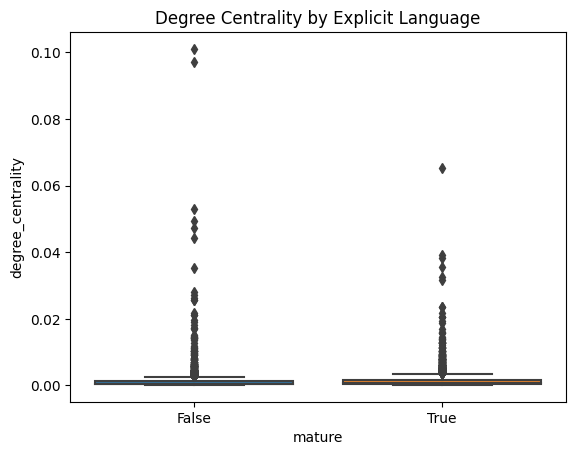

__________________________________________________________________________________________________________________________________________________
T-test (Degree Centrality, explicit vs non-explicit language): t=2.93346, p=0.0033656
__________________________________________________________________________________________________________________________________________________


In [20]:
# Visualize Distribution for DC
sns.boxplot(x="mature", y="degree_centrality", data=data)
plt.title("DC by Explicit Language")
plt.show()
print("__________________________________________________________________________________________________________________________________________________")

# Statistical Test DC 
mature = data.loc[data["mature"], "degree_centrality"]
non_mature = data.loc[~data["mature"], "degree_centrality"]
t, p = ttest_ind(mature, non_mature, equal_var=False)
print(f"T-test (DC, explicit vs non-explicit language): t={t:.5f}, p={p:.5g}")
print("__________________________________________________________________________________________________________________________________________________")

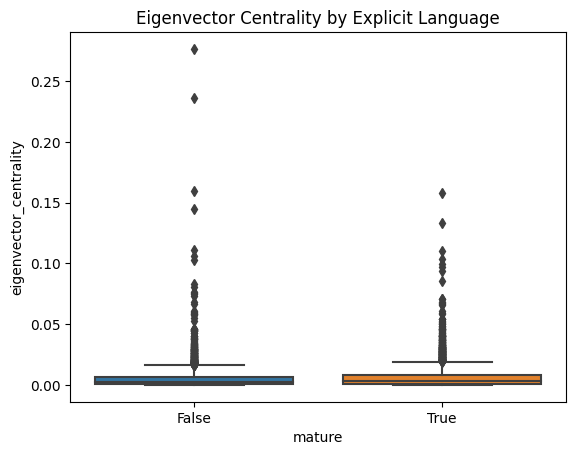

__________________________________________________________________________________________________________________________________________________
T-test (eigenvector centrality, explicit vs non-explicit language): t=2.88083, p=0.0039796


In [24]:
# Visualize Distribution for EC
sns.boxplot(x="mature", y="eigenvector_centrality", data=data)
plt.title("Eigenvector Centrality by Explicit Language")
plt.show()
print("__________________________________________________________________________________________________________________________________________________")

# Statistical Test EC
mature_eig = data.loc[data["mature"], "eigenvector_centrality"]
non_mature_eig = data.loc[~data["mature"], "eigenvector_centrality"]
t_eig, p_eig = ttest_ind(mature_eig, non_mature_eig, equal_var=False)
print(f"T-test (eigenvector centrality, explicit vs non-explicit language): t={t_eig:.5f}, p={p_eig:.5g}")

The statistical test checks if the relationship is due to random chance, or a real effect in the data. It checks the null hypothesis (no effect; centrality and explicit language are unrelated) vs the alternative hypothesis (central users are more/less likely to use the language). t = 2.93 measures how far apart the group means are in their distribution, relative to their variability. The low p-value of 0.03 is the probability of seeing a difference this large if the null hypothesis is true. Since it is < 0.05, I reject the null and take the alternative hypothesis. Which means that there are different cluster behaviors between users with explicit vs. non-explicit language, likely more centrality and density. 

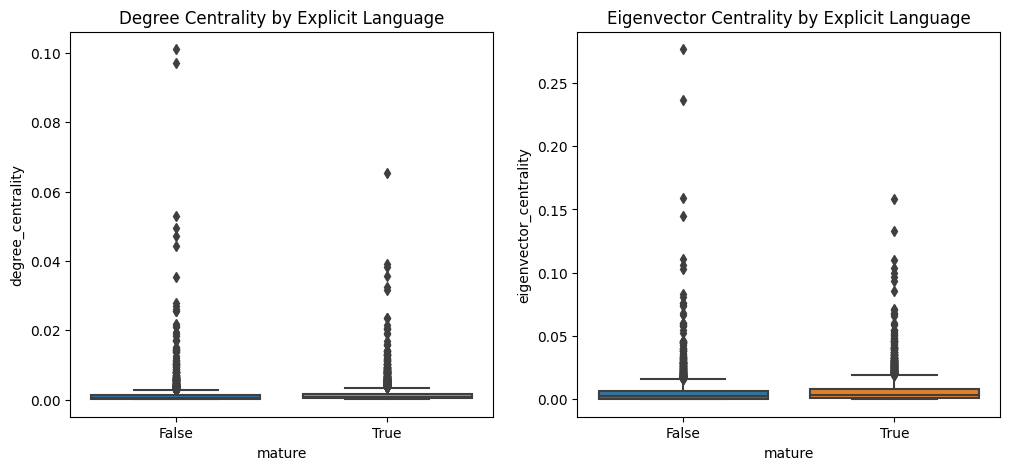

In [26]:
# Compare side by side 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="mature", y="degree_centrality", data=data, ax=axes[0])
axes[0].set_title("Degree Centrality by Explicit Language")
sns.boxplot(x="mature", y="eigenvector_centrality", data=data, ax=axes[1])
axes[1].set_title("Eigenvector Centrality by Explicit Language")
plt.show()

In [27]:
# Summary by 'mature' category
summary_mature = data.groupby("mature")[["degree_centrality", "eigenvector_centrality"]].mean().reset_index()
summary_mature["category"] = "mature"

# Summary by 'partner' category
summary_partner = data.groupby("partner")[["degree_centrality", "eigenvector_centrality"]].mean().reset_index()
summary_partner["category"] = "partner"

# Combine both summaries
summary_df = pd.concat([summary_mature, summary_partner], ignore_index=True)
summary_df = summary_df.rename(columns={True: "group_true", False: "group_false"}, errors="ignore")

print(summary_df.head())

  mature  degree_centrality  eigenvector_centrality category partner
0  False           0.001269                0.005533   mature     NaN
1   True           0.001493                0.006247   mature     NaN
2    NaN           0.001085                0.005092  partner   False
3    NaN           0.006777                0.020514  partner    True


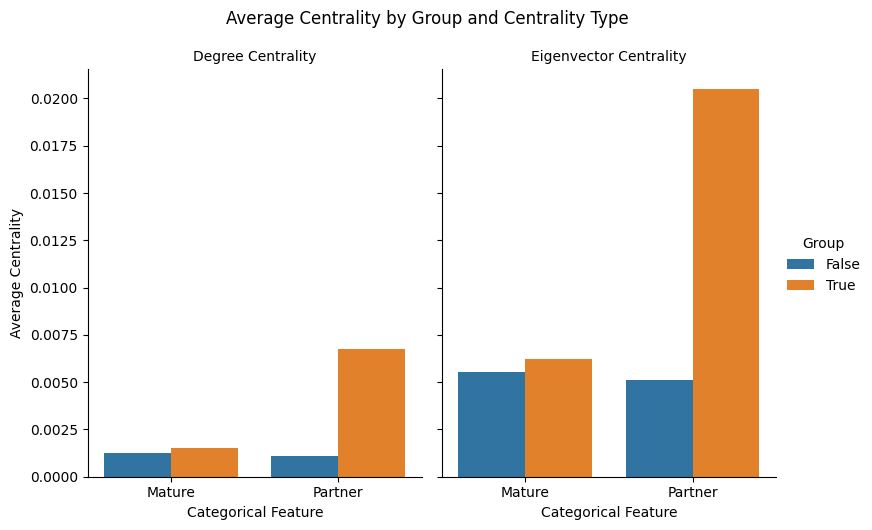

In [46]:
# Prepare summary table 
summary_mature = summary_mature.rename(columns={"mature": "group"})
summary_mature["category"] = "Mature"

summary_partner = summary_partner.rename(columns={"partner": "group"})
summary_partner["category"] = "Partner"

summary_clean = pd.concat([summary_mature, summary_partner], ignore_index=True)

# Melt for easier plotting
summary_melt = summary_clean.melt(id_vars=["category", "group"], 
                                  value_vars=["degree_centrality", "eigenvector_centrality"],
                                  var_name="Centrality_Type",
                                  value_name="Centrality_Value")


# Replace column names with nicer labels
summary_melt["Centrality_Type"] = summary_melt["Centrality_Type"].replace({ "degree_centrality": "DC", 
                                                                           "eigenvector_centrality": "Eigenvector Centrality"})


# Plot
# Define custom colors
#custom_palette = {False: "black", True: "green"}

# Plot with custom colors
# Separate plots for Degree vs Eigenvector Centrality
g = sns.catplot(
    x="category",
    y="Centrality_Value",
    hue="group",
    col="Centrality_Type",        # creates separate panels
    data=summary_melt,
    kind="bar",
    #palette={False: "black", True: "#50C878"},
    height=5,
    aspect=0.8,
    legend_out=True
)

g.set_axis_labels("Categorical Feature", "Average Centrality")
g.set_titles("{col_name}")  # show Degree/Eigenvector as panel titles
g.fig.suptitle("Average Centrality by Group and Centrality Type", y=1.05)
g._legend.set_title("Group")
plt.show()

Users with explicit language have slightly higher average DC and EC than those who don't, so there is higher connectivity in that group of Twitch users, and they tend to connect to more influential users. As for the Twitch partners, they have a higher DC and EC too. This means their partners are more connected in the user network and are more connected to influential users. Therefore, partners are more central and influential in the network than other users.

Now I will trim and subset my data to the densest cluster of nodes. Iterating to see what proportion each node threshold corresponds to, and then further core analysis based on the above.

In [34]:
# Number of nodes in the graph
num_nodes = G.number_of_nodes()
print("Total nodes in the graph:", num_nodes)

# Degree of each node
degrees = dict(G.degree())

# Minimum and maximum degree
min_degree = min(degrees.values())
max_degree = max(degrees.values())
print(f"Minimum degree: {min_degree}")
print(f"Maximum degree: {max_degree}")
print("__________________________________________________________________________________________________________________________________________________")

# Define thresholds
thresholds = [5, 10, 15, 20, 25]

# Compute number of nodes with degree above each threshold
for d in thresholds:
    nodes_above_d = sum(1 for deg in degrees.values() if deg > d)
    print(f"Nodes with degree > {d}: {nodes_above_d}")

Total nodes in the graph: 7126
Minimum degree: 1
Maximum degree: 720
__________________________________________________________________________________________________________________________________________________
Nodes with degree > 5: 3162
Nodes with degree > 10: 1805
Nodes with degree > 15: 1101
Nodes with degree > 20: 738
Nodes with degree > 25: 518


In [39]:
# Node Trim function
def trim_nodes(G, d):
    #Returns a copy of G without nodes with degree <= d
    Gt = G.copy()
    dn = dict(Gt.degree())
    for n in list(Gt.nodes()):
        if dn[n] <= d:
            Gt.remove_node(n)
    return Gt

# Trim nodes with degree <= 25. This is my core.
G_core = trim_nodes(G, 25)

print("Trimmed graph:")
print("Nodes:", G_core.number_of_nodes())
print("Edges:", G_core.number_of_edges())

density_core = nx.density(G_core)
print(f"Density of trimmed graph: %:{density_core*100:.5g}")

Trimmed graph:
Nodes: 518
Edges: 5437
Density of trimmed graph: %:4.0604


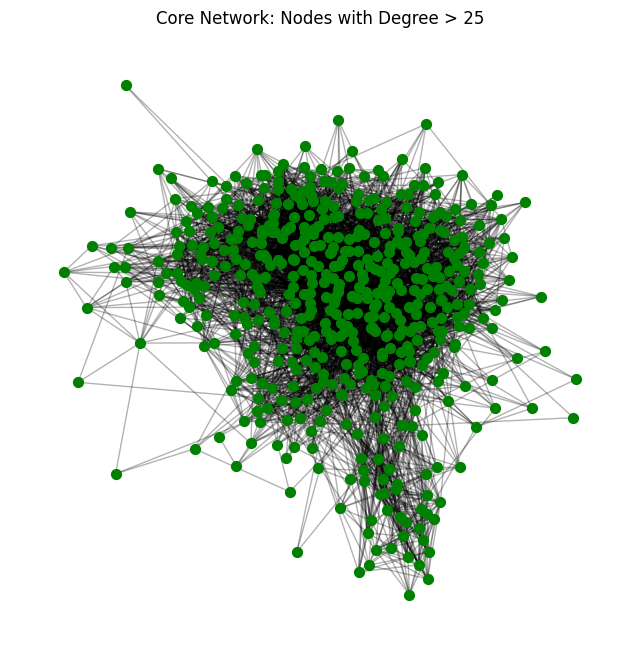

In [42]:
# Plot core
plt.figure(figsize=(8,8))
# for consistent layout
pos = nx.spring_layout(G_core, seed=42)  
nx.draw_networkx_nodes(G_core, pos, node_size=50, node_color="green")
nx.draw_networkx_edges(G_core, pos, alpha=0.3)
plt.title("Core Network: Nodes with Degree > 25")
plt.axis("off")
plt.show()

In [43]:
# DC
deg_centrality_core = nx.degree_centrality(G_core)
nx.set_node_attributes(G_core, deg_centrality_core, "degree_centrality")

# Eigenvector Centrality
eig_centrality_core = nx.eigenvector_centrality(G_core, max_iter=1000)
nx.set_node_attributes(G_core, eig_centrality_core, "eigenvector_centrality")

# Create DataFrame with node attributes
data_core = pd.DataFrame.from_dict(dict(G_core.nodes(data=True)), orient="index")
print("Core graph node attributes head():")
print(data_core.head())

Core graph node attributes head():
             id  days  mature     views  partner  \
986    51988813  1780    True      8011    False   
4282  126281499   856    True    110308    False   
3401   15310631  2959    True  20253246     True   
6611   73447747  1453   False     12701    False   
5842    3481156  3556   False   7448777     True   

                                               features  degree_centrality  \
986   [1948, 421, 2556, 861, 213, 2063, 920, 224, 81...           0.013540   
4282  [515, 294, 1936, 2928, 1785, 2003, 920, 224, 8...           0.019342   
3401  [1234, 3152, 2025, 846, 1582, 1747, 2814, 119,...           0.098646   
6611  [1234, 3152, 1294, 653, 1093, 1649, 920, 224, ...           0.017408   
5842  [1234, 3152, 2263, 48, 266, 2814, 119, 1644, 2...           0.201161   

      eigenvector_centrality  
986                 0.011585  
4282                0.023693  
3401                0.069020  
6611                0.007376  
5842                0.184820

In [47]:
# Summary for mature
summary_mature_core = data_core.groupby("mature")[["degree_centrality", "eigenvector_centrality"]].mean().reset_index()
summary_mature_core = summary_mature_core.rename(columns={"mature": "group"})
summary_mature_core["category"] = "Mature"

# Summary for partner
summary_partner_core = data_core.groupby("partner")[["degree_centrality", "eigenvector_centrality"]].mean().reset_index()
summary_partner_core = summary_partner_core.rename(columns={"partner": "group"})
summary_partner_core["category"] = "Partner"

# Combine summaries
summary_clean_core = pd.concat([summary_mature_core, summary_partner_core], ignore_index=True)

# Melt for plotting
summary_melt_core = summary_clean_core.melt(id_vars=["category", "group"],
                                            value_vars=["degree_centrality", "eigenvector_centrality"],
                                            var_name="Centrality_Type",
                                            value_name="Centrality_Value")

# Rename centrality types for nicer plot labels
summary_melt_core["Centrality_Type"] = summary_melt_core["Centrality_Type"].replace({
    "degree_centrality": "DC",
    "eigenvector_centrality": "Eigenvector Centrality"
})

print("Summary core head():")
print(summary_melt_core.head())


Summary core head():
  category  group         Centrality_Type  Centrality_Value
0   Mature  False       Degree Centrality          0.038886
1   Mature   True       Degree Centrality          0.041616
2  Partner  False       Degree Centrality          0.037732
3  Partner   True       Degree Centrality          0.046138
4   Mature  False  Eigenvector Centrality          0.031046


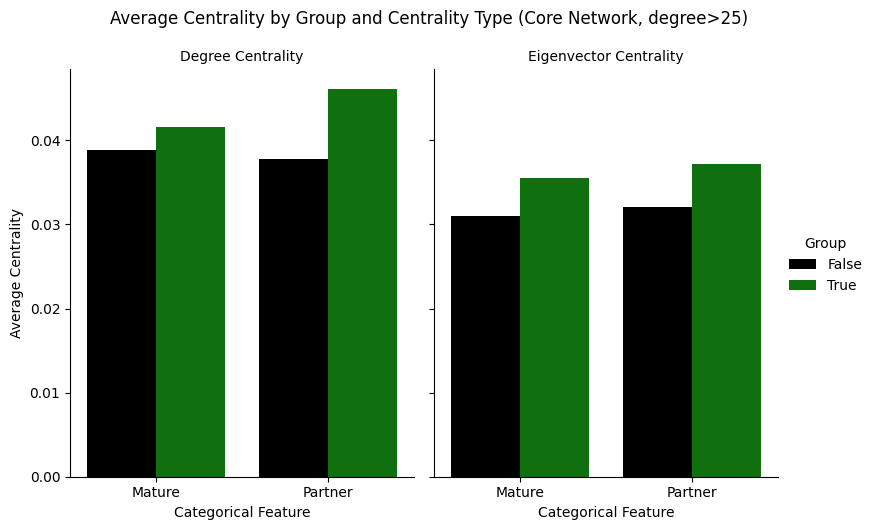

In [52]:
# Plot
g = sns.catplot(
    x="category",
    y="Centrality_Value",
    hue="group",
    col="Centrality_Type",
    data=summary_melt_core,
    kind="bar",
    palette={False: "black", True: "green"},
    height=5,
    aspect=0.8,
    legend_out=True
)

g.set_axis_labels("Categorical Feature", "Average Centrality")
g.set_titles("{col_name}")
g.fig.suptitle("Average Centrality by Group and Centrality Type (Core Network, degree>25)", y=1.05)
g._legend.set_title("Group")
plt.show()

In [50]:
# Sort core network nodes by eigenvector centrality
top_nodes = data_core.sort_values(by="eigenvector_centrality", ascending=False).head(10)

# Display top 10 user nodes
top_nodes_info = top_nodes[["id", "mature", "partner", "degree_centrality", "eigenvector_centrality", "views", "days"]]
print(top_nodes_info)

             id  mature  partner  degree_centrality  eigenvector_centrality  \
5842    3481156   False     True           0.201161                0.184820   
4196   68707904    True     True           0.193424                0.182379   
2345   60979446    True    False           0.181818                0.172589   
6716   71040143   False     True           0.164410                0.165841   
792    77367177    True     True           0.150870                0.151919   
4949   23735582   False     True           0.212766                0.146862   
2447     497952    True     True           0.154739                0.130763   
5569  102970038    True    False           0.117988                0.123381   
1924   60264946   False     True           0.135397                0.120357   
24     60047423   False     True           0.096712                0.119928   

         views  days  
5842   7448777  3556  
4196    717298  1523  
2345     12825  1640  
6716    971621  1491  
792     526969 

With the network trimmed to the densest core, we see the most highly connected Twitch users that function as hubs in the network. The DC ranges from 0.01 to 0.2, and EC ranges from 0.007 to 0.18, which as expected, means some nodes are much more influential in the network than others. Users with explicit language have a slightly higher average DC and EC than those who don't, re-enforcing my prior hypothesis. For curiosity, plotting the EC/DC for these 10 users.

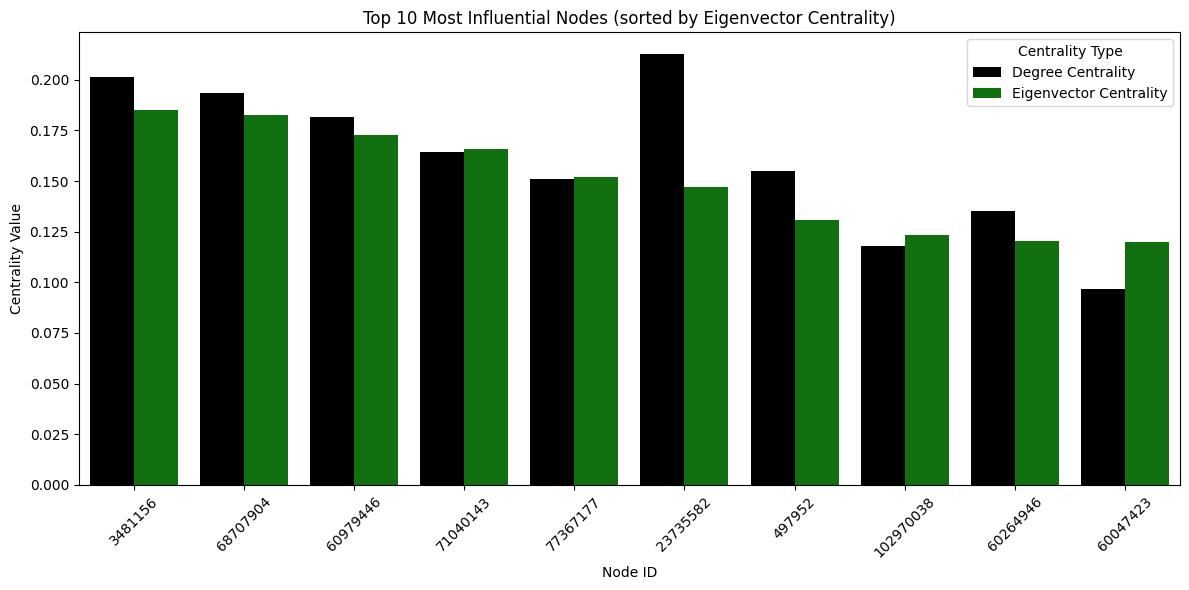

In [53]:
# Top 10 nodes by eigenvector centrality, sorted descending
top_nodes = data_core.sort_values(by="eigenvector_centrality", ascending=False).head(10)

# Keep the sorting order for plotting
top_nodes["id"] = pd.Categorical(top_nodes["id"], categories=top_nodes["id"], ordered=True)

# Prepare data for plotting
top_nodes_plot = top_nodes[["id", "degree_centrality", "eigenvector_centrality"]].melt(
    id_vars="id", 
    value_vars=["degree_centrality", "eigenvector_centrality"],
    var_name="Centrality_Type",
    value_name="Centrality_Value"
)

# Rename labels
top_nodes_plot["Centrality_Type"] = top_nodes_plot["Centrality_Type"].replace({
    "degree_centrality": "Degree Centrality",
    "eigenvector_centrality": "Eigenvector Centrality"
})

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="id", y="Centrality_Value", hue="Centrality_Type", data=top_nodes_plot, palette=["black", "green"])
plt.xticks(rotation=45)
plt.xlabel("Node ID")
plt.ylabel("Centrality Value")
plt.title("Top 10 Most Influential Nodes (sorted by Eigenvector Centrality)")
plt.legend(title="Centrality Type")
plt.tight_layout()
plt.show()
